In [1]:
%matplotlib inline
import numpy as np
from sklearn import base, linear_model, datasets, preprocessing
from sympy import var, exp, plot, diff, solve, tanh, functions, stats
import enum
from typing import List, Callable
from toolz import pipe

import matplotlib.pyplot as plt
Tensor = np.array

import netdraw as netdraw

In [2]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

Y = np.array([[0,1,1,0]]).T

sig = lambda z: 1 / (1 + np.exp(-z))
sig_prime = lambda z: z * (1-z)

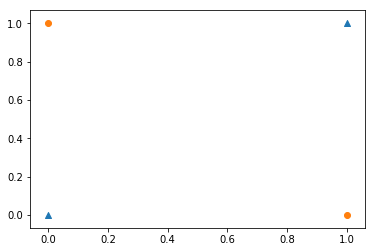

In [3]:
plt.scatter(X[[0,3],0],X[[0,3],1], marker='^', )
plt.scatter(X[[1,2],0],X[[1,2],1], marker='o', )

In [4]:
lm = linear_model.LinearRegression().fit(X,Y)
lm.predict(X).reshape(-1,1)

array([[0.5],
       [0.5],
       [0.5],
       [0.5]])

In [5]:
clf = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X, np.ravel(Y))
clf.predict(X).reshape(-1,1)

array([[0],
       [0],
       [0],
       [0]])

In [6]:
def aux(X):
    return X.sum(axis=1)[None].T % 2
X[:, :2].sum(axis=1)[None] %2
# can do feature extraction if we know about the data

array([[0, 1, 1, 0]])

In [7]:
clf = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(aux(X), np.ravel(Y))
clf.predict(aux(X).reshape(-1,1))

array([0, 1, 1, 0])

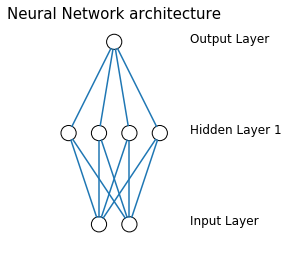

In [8]:
network = netdraw.DrawNN([2,4,1])
network.draw()

Component of the NN: $$E = -\frac{1}{2}(y-\hat{y})^2$$

$$\hat{y} = \sigma(X) $$

where $$  \sigma (X) =  \frac{\mathrm{1} }{\mathrm{1} + e^{- X} }  $$ 

$$X = ZB^T $$

Z is previous layer

Derivative of components:
$$\frac{\partial E}{\partial \hat{y}} = y-\hat{y}$$

$$\frac{\partial \hat{y} }{\partial X} = \sigma(X) (1 - \sigma(X))$$

$$\frac{\partial X }{\partial B^T} = Z$$

$$\frac{\partial X }{\partial Z} = B^T$$

Use the chain rule:
    
$$\frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y} }{\partial X} \frac{\partial X }{\partial B^T}$$

to get:

$$\frac{\partial E}{\partial{B^T}}$$

or:

$$\frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y} }{\partial X} \frac{\partial X }{\partial Z}$$

to get:

$$\frac{\partial E}{\partial{Z}}$$

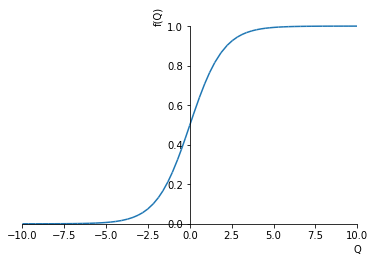

In [9]:
sig = lambda z: 1 / (1 + np.exp(-z))
sig_prime = lambda z: z * (1-z)

var('Q')
s = lambda Q: 1 / (1 + exp(-Q))
plot(s(Q))

In [10]:
betas0_1 = np.random.random(size=(2,4)) # randomise my betas to start the algorithim
betas1_2 = np.random.random(size=(4,1)) 

lr = 16 # constant for gradient descent

betas = np.zeros((30000,4)) # To track convergence

for i in range(30000):
    # forward pass of the NN
    layer0 = X #  input we use all training data in one pass
    layer1 = sig(layer0 @ betas0_1) 
    layer2 = sig(layer1 @ betas1_2) # y_hat
    

    # backward pass of NN
    layer2_loss = layer2 - Y # output layer loss 
    layer2_delta = layer2_loss * sig_prime(layer2) # Use derivative calculations and backpropigate 
    grad1_2 = layer1.T @ layer2_delta # the gradient to descend second betas
    
    layer1_loss = layer2_delta @ betas1_2.T # backproped error
    layer1_delta = layer1_loss * sig_prime(layer1)
    grad0_1 = layer0.T @ layer1_delta # the gradient to descend first betas
    
    betas0_1 = betas0_1 - (lr * grad0_1) # update through descent
    betas1_2 = betas1_2 - (lr * grad1_2)
    
    betas[i,:] = betas1_2.reshape(1,-1)
else:
    print(np.round(layer2,1))

    

[[0.]
 [1.]
 [1.]
 [0.]]


In [11]:
# one single training point forward pass
layer0_a = X[0,:].reshape(1,-1)
layer1_a = sig(layer0_a @ betas0_1)
layer2_a = sig(layer1_a @ betas1_2)
print(np.round(layer2_a,1))

[[0.]]


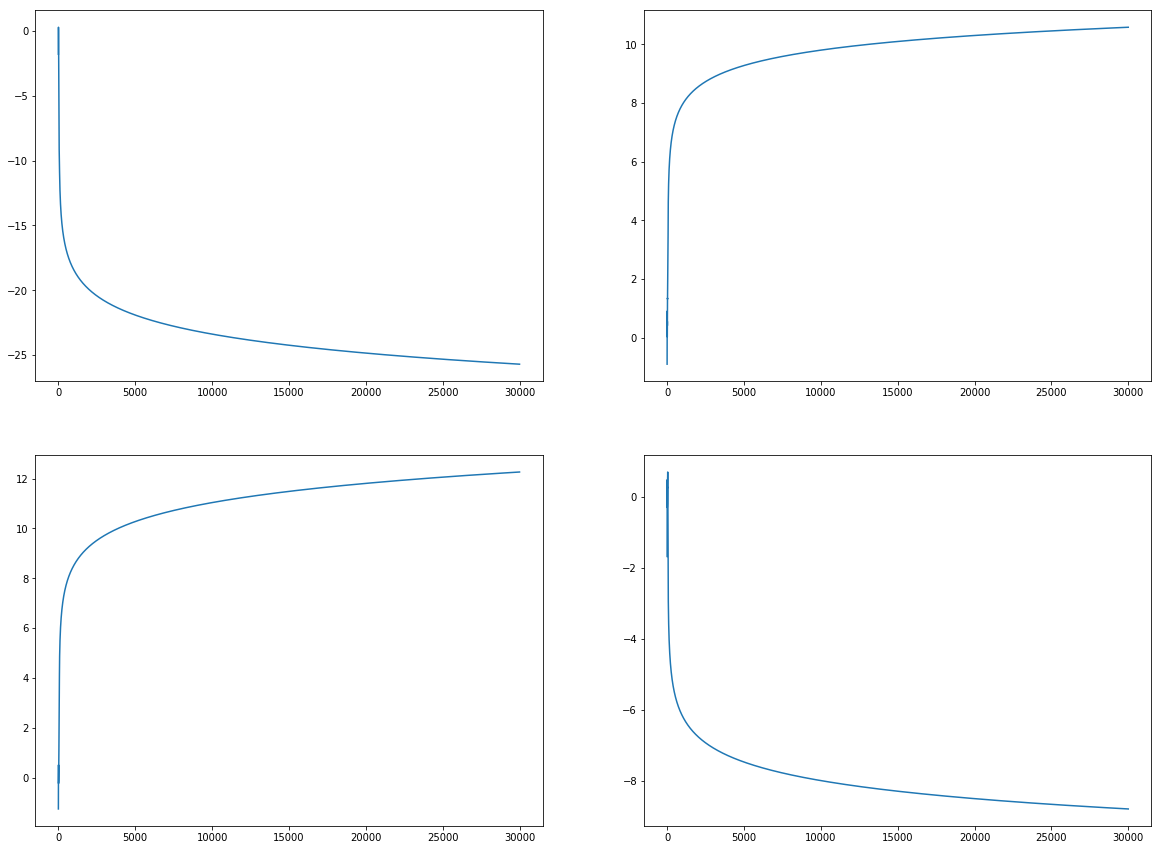

In [12]:
#Betas show convergence of gradient descent
plt.figure(figsize=(20,15))
for i in range(4):
    plt.subplot(220+(1+i))
    plt.plot(betas[:,i])


In [13]:
class LayerKind(enum.Enum):
    # Python enumeration of our activation functions
    
    SIGMOID = (sig, sig_prime)
    TANH = (np.tanh, lambda z: 1 - z ** 2)
    
    def __init__(self,fn: Callable, fn_prime: Callable):
        self.fn = fn
        self.fn_prime = fn_prime
        
K = LayerKind

In [14]:
print(K.TANH.fn_prime)

<function LayerKind.<lambda> at 0x7f6a5838b488>


In [15]:
class Layer:
    '''The workhorse object
       will intiate instances of this for every layer, update and store the betas to use
       and calculate error for previous layer'''
    def __init__(self,kind: LayerKind, shape: tuple) -> None:
        #initalize with shape and function you want to use
        
        self.fn = kind.fn
        self.fn_prime = kind.fn_prime
        self.betas = np.random.random(shape) 
        
    def forward(self, layer_input: Tensor) -> Tensor:
        # pass forward method
        
        self.input = layer_input
        self.out = self.fn(self.input @ self.betas)
        return self.out
    
    def backward(self, this_layer_loss: Tensor) -> Tensor:
        # pass back method updates betas and calcs previous layer error
        
        error_signal = this_layer_loss * self.fn_prime(self.out)
        grad = self.input.T @ error_signal
        self.betas = self.betas - 0.8 * grad
        prev_layer_loss = error_signal @ self.betas.T
        return prev_layer_loss
    ''' 
    self.out: 1Xk
    this_layer_loss: 1Xk
    error_signal:1Xk
    self.betas: nXk
    grad: nXk
    self.input: 1Xn
    prev_layer_loss: 1Xn
    
    n is number of previous layer nodes
    k is number of neurons in this layer
    '''
        

In [16]:
class NN:
    """This class holds all the layers and runs the the fit and predict methods
       to train the whole network"""
    def __init__(self,layers: List[Layer]):
        self.layers = layers
        
    def _forward(self, X: Tensor) -> Tensor:
        return pipe(X,*(layer.forward for layer in self.layers))
        # pipe puts the data through a function in order
    
    def _backward(self, last_layer_loss: Tensor) -> None:
        pipe(last_layer_loss, *(layer.backward for layer in reversed(self.layers)))
        # order must be reversed to go backwards
        
    def fit(self, X: Tensor, Y: Tensor) -> 'NN':
        for _ in range(60000):
            self._backward(self._forward(X) -Y)
        return self
    
    predict_proba = _forward
    
    def predict(self, X: Tensor) -> Tensor:
        return pipe(X, self.predict_proba, np.round, lambda a: a.astype(int))

In [17]:
XOR = NN(layers=[
        Layer(kind=K.SIGMOID,shape=(2,4)),
        Layer(kind=K.SIGMOID,shape=(4,1)),
]).fit(X,Y)

XOR.predict(X)


array([[0],
       [1],
       [1],
       [0]])

In [18]:
XOR = NN(layers=[
        Layer(kind=K.SIGMOID,shape=(2,2)),
        Layer(kind=K.SIGMOID,shape=(2,1)),
]).fit(X,Y)

XOR.predict(X)

array([[0],
       [1],
       [1],
       [0]])

In [19]:
XOR = NN(layers=[
        Layer(kind=K.SIGMOID,shape=(2,2)),
        Layer(kind=K.TANH,shape=(2,4)),
        Layer(kind=K.SIGMOID,shape=(4,1)),
]).fit(X,Y)

XOR.predict(X)

array([[0],
       [1],
       [1],
       [0]])

In [20]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(4,), random_state=1)

In [21]:
clf.fit(X, np.ravel(Y))
clf.predict(X)

array([0, 1, 1, 0])

In [22]:
#add noise to my data vector
X_t =  np.array([[0,0,0], 
                 [0,0,1],
                 [0,1,0],
                 [0,1,1],
                 [1,0,0],
                 [1,0,1],
                 [1,1,0],
                 [1,1,1]])

X_n = np.hstack(( np.vstack((X,X)),X_t))
Y_n = np.vstack((Y,Y))

In [27]:
Y_n

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [28]:
XOR_n = NN(layers=[
        Layer(kind=K.SIGMOID,shape=(5,2)),
        Layer(kind=K.SIGMOID,shape=(2,1)),
]).fit(X_n,Y_n)

XOR_n.predict(X_n) == Y_n

array([[ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True]])

In [29]:
# Increase complexity of network to solve
XOR_n = NN(layers=[
        Layer(kind=K.SIGMOID,shape=(5,10)),
        Layer(kind=K.SIGMOID,shape=(10,2)),
        Layer(kind=K.SIGMOID,shape=(2,1)),
]).fit(X_n,Y_n)

XOR_n.predict(X_n) == Y_n

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])